In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import os

# Q1

## Read 1.jpg image

array([[[241, 144, 189],
        [241, 139, 186],
        [245, 132, 184],
        ...,
        [147, 118, 140],
        [151, 125, 150],
        [156, 132, 158]],

       [[246, 147, 191],
        [247, 144, 191],
        [250, 138, 188],
        ...,
        [175, 156, 176],
        [176, 161, 184],
        [179, 165, 190]],

       [[250, 147, 190],
        [252, 145, 189],
        [255, 141, 192],
        ...,
        [184, 182, 203],
        [185, 187, 210],
        [188, 192, 217]],

       ...,

       [[233,  70,  71],
        [219,  45,  55],
        [211,  13,  48],
        ...,
        [199, 137,  50],
        [199, 129,  57],
        [178, 104,  39]],

       [[225,  59,  63],
        [218,  39,  58],
        [218,  12,  58],
        ...,
        [166, 107,  27],
        [168, 101,  33],
        [148,  78,  18]],

       [[227,  62,  66],
        [227,  48,  67],
        [233,  23,  70],
        ...,
        [142,  84,  11],
        [143,  79,  17],
        [128,  62,   4]]], dtype=uint8)
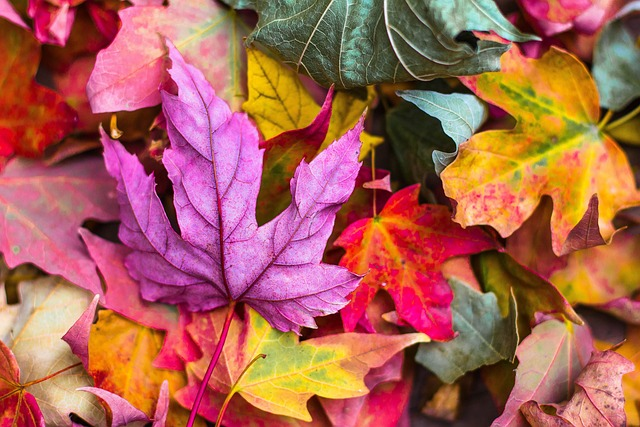

In [5]:
rgb_image = cv2.imread("/content/1.jpg")
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
rgb_image

## Q1.1: RGB to CMYK & CMYK to RGB

In [17]:
def RGB_to_CMYK(r, g, b, RGB_SCALE=255, CMYK_SCALE=100):
    """
    Convert RGB color values to CMYK color values.

    Args:
        r (int): Red component value (0 to 255).
        g (int): Green component value (0 to 255).
        b (int): Blue component value (0 to 255).
        RGB_SCALE (int, optional): Scale factor for RGB values. Defaults to 255.
        CMYK_SCALE (int, optional): Scale factor for CMYK values. Defaults to 100.

    Returns:
        tuple: CMYK color values as floats in the range of 0 to CMYK_SCALE.
    """
    # Convert RGB [0, 255] to [0, 1]
    r_norm = r / RGB_SCALE
    g_norm = g / RGB_SCALE
    b_norm = b / RGB_SCALE

    # Find the maximum of normalized RGB values
    max_rgb = max(r_norm, g_norm, b_norm)

    # Calculate key (black) component
    k = 1 - max_rgb

    # Avoid division by zero if black is 1
    if k == 1:
        return 0, 0, 0, CMYK_SCALE

    # Calculate CMY values
    c = (1 - r_norm - k) / (1 - k)
    m = (1 - g_norm - k) / (1 - k)
    y = (1 - b_norm - k) / (1 - k)

    # Scale CMYK values to the desired scale
    c = c * CMYK_SCALE
    m = m * CMYK_SCALE
    y = y * CMYK_SCALE
    k = k * CMYK_SCALE

    return c, m, y, k


In [19]:
def CMYK_to_RGB(c, m, y, k, RGB_SCALE=255, CMYK_SCALE=100):
    """
    Convert CMYK color values to RGB color values.

    Args:
        c (float): Cyan component value (0 to CMYK_SCALE).
        m (float): Magenta component value (0 to CMYK_SCALE).
        y (float): Yellow component value (0 to CMYK_SCALE).
        k (float): Key (black) component value (0 to CMYK_SCALE).
        RGB_SCALE (int, optional): Scale factor for RGB values. Defaults to 255.
        CMYK_SCALE (int, optional): Scale factor for CMYK values. Defaults to 100.

    Returns:
        tuple: RGB color values as integers in the range of 0 to RGB_SCALE.
    """
    # Convert CMYK [0, CMYK_SCALE] to [0, 1]
    c_norm = c / CMYK_SCALE
    m_norm = m / CMYK_SCALE
    y_norm = y / CMYK_SCALE
    k_norm = k / CMYK_SCALE

    # Calculate RGB values
    r = RGB_SCALE * (1 - min(1, c_norm * (1 - k_norm) + k_norm))
    g = RGB_SCALE * (1 - min(1, m_norm * (1 - k_norm) + k_norm))
    b = RGB_SCALE * (1 - min(1, y_norm * (1 - k_norm) + k_norm))

    return int(r), int(g), int(b)


## Q1.2: RGB to HSI

In [21]:
import math

def RGB_to_HSI(r, g, b):
    """
    Convert RGB color values to HSI color space.

    Args:
        r (int): Red component value (0 to 255).
        g (int): Green component value (0 to 255).
        b (int): Blue component value (0 to 255).

    Returns:
        tuple: HSI color values (hue, saturation, intensity).
    """
    # Convert RGB values to the range [0, 1]
    r_norm = r / 255.0
    g_norm = g / 255.0
    b_norm = b / 255.0

    # Calculate intensity
    i = (r_norm + g_norm + b_norm) / 3.0

    # Calculate saturation
    if i > 0:
        s = 1 - min(r_norm, g_norm, b_norm) / i
    else:
        s = 0

    # Avoid division by zero for hue calculation
    if r_norm == g_norm == b_norm:
        h = 0
    else:
        theta = math.acos(0.5 * ((r_norm - g_norm) + (r_norm - b_norm)) / math.sqrt((r_norm - g_norm) ** 2 + (r_norm - b_norm) * (g_norm - b_norm)))
        if b_norm <= g_norm:
            h = math.degrees(theta)
        else:
            h = 360 - math.degrees(theta)

    return h, s, i


## Show result image for all functions

In [27]:
# Get the height and width of the image
height, width, _ = rgb_image.shape

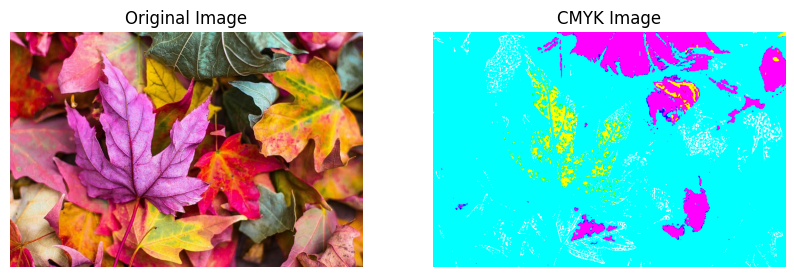

In [28]:
# Create arrays to store CMYK channels
c_channel = np.zeros((height, width), dtype=np.float32)
m_channel = np.zeros((height, width), dtype=np.float32)
y_channel = np.zeros((height, width), dtype=np.float32)
k_channel = np.zeros((height, width), dtype=np.float32)

# Convert RGB image to CMYK
for i in range(height):
    for j in range(width):
        # Get RGB values of the pixel
        r, g, b = rgb_image[i, j]

        # Convert RGB to CMYK
        c, m, y, k = RGB_to_CMYK(r, g, b)

        # Store CMYK values in the corresponding channels
        c_channel[i, j] = c
        m_channel[i, j] = m
        y_channel[i, j] = y
        k_channel[i, j] = k

# Merge CMYK channels into a single image
cmyk_img = cv2.merge((c_channel, m_channel, y_channel, k_channel))

# Display the original image and CMYK image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cmyk_img)
plt.title('CMYK Image')
plt.axis('off')

plt.show()

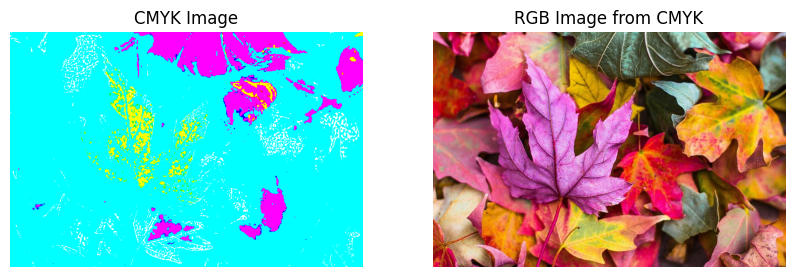

In [29]:
# Create arrays to store RGB channels
r_channel = np.zeros((height, width), dtype=np.uint8)
g_channel = np.zeros((height, width), dtype=np.uint8)
b_channel = np.zeros((height, width), dtype=np.uint8)

# Convert CMYK image to RGB
for i in range(height):
    for j in range(width):
        # Get CMYK values of the pixel
        c, m, y, k = cmyk_img[i, j]

        # Convert CMYK to RGB
        r, g, b = CMYK_to_RGB(c, m, y, k)

        # Store RGB values in the corresponding channels
        r_channel[i, j] = r
        g_channel[i, j] = g
        b_channel[i, j] = b

# Merge RGB channels into a single image
rgb_image_from_cmyk = cv2.merge((r_channel, g_channel, b_channel))

# Display the CMYK image and the RGB image converted from CMYK
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cmyk_img)
plt.title('CMYK Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rgb_image_from_cmyk)
plt.title('RGB Image from CMYK')
plt.axis('off')

plt.show()


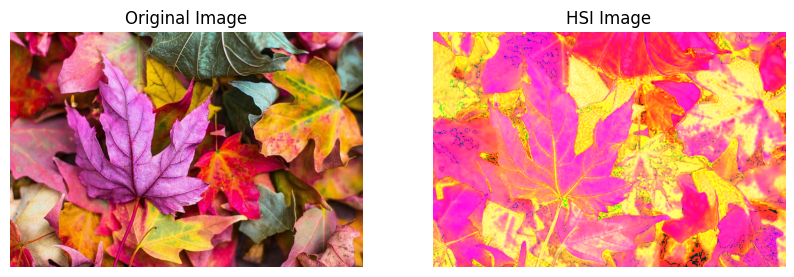

In [30]:

# Create arrays to store HSI channels
h_channel = np.zeros((height, width), dtype=np.float32)
s_channel = np.zeros((height, width), dtype=np.float32)
i_channel = np.zeros((height, width), dtype=np.float32)

# Convert RGB image to HSI
for i in range(height):
    for j in range(width):
        # Get RGB values of the pixel
        r, g, b = rgb_image[i, j]

        # Convert RGB to HSI
        h, s, intensity = RGB_to_HSI(r, g, b)

        # Store HSI values in the corresponding channels
        h_channel[i, j] = h
        s_channel[i, j] = s
        i_channel[i, j] = intensity

# Merge HSI channels into a single image
hsi_image = cv2.merge((h_channel, s_channel, i_channel))

# Display the original image and HSI image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hsi_image)
plt.title('HSI Image')
plt.axis('off')

plt.show()

# Q2

## Read images

In [42]:
# Read and convert image 2
image_2 = cv2.imread('/content/2.jpg')
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

# Read and convert image 3
image_3 = cv2.imread('/content/3.jpg')
image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB)

## Find differences between two pictures

In [56]:
def diff (image1, image2):
    """
    Compute the absolute difference between two images, with unchanged pixels set to black.

    Args:
        image1 (numpy.ndarray): First input image.
        image2 (numpy.ndarray): Second input image.

    Returns:
        numpy.ndarray: Image showing the absolute difference between the two input images.
    """
    # Resize image1 to match the image2
    resized_image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))

    # Compute  diference between images
    diff_image = cv2.absdiff(resized_image1, image2)

    return diff_image


## Show result

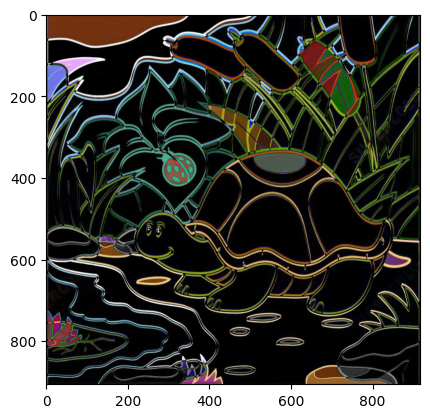

In [57]:
differences = diff(image_2, image_3)
plt.imshow(differences)
plt.show()